In [15]:
from pathlib import Path
from typing import Any, Dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {"grid.color": ".7", "grid.linestyle": ":"})
sns.set_context("notebook")
sns.set_palette("RdYlBu")

In [16]:
DATA_DIR = Path("../out")

CVE_PATH = DATA_DIR / "gojwt-cve-results.csv"
FIXED_PATH = DATA_DIR / "gojwt-fixed-results.csv"

assert CVE_PATH.exists(), f"File not found: {CVE_PATH.resolve()}"
assert FIXED_PATH.exists(), f"File not found: {FIXED_PATH.resolve()}"

print(f"Loading CVE version: {CVE_PATH}")
print(f"Loading Fixed version: {FIXED_PATH}")

Loading CVE version: ../out/gojwt-cve-results.csv
Loading Fixed version: ../out/gojwt-fixed-results.csv


In [17]:
df_cve = pd.read_csv(CVE_PATH, low_memory=False)
df_fixed = pd.read_csv(FIXED_PATH, low_memory=False)

print(f"{df_cve.shape} - CVE data shape")
print(f"{df_fixed.shape} - Fixed data shape")

print(f"Columns of CVE data: {df_cve.columns}")

(1338229, 19) - CVE data shape
(1508051, 19) - Fixed data shape
Columns of CVE data: Index(['metric_name', 'timestamp', 'metric_value', 'check', 'error',
       'error_code', 'expected_response', 'group', 'method', 'name', 'proto',
       'scenario', 'service', 'status', 'subproto', 'tls_version', 'url',
       'extra_tags', 'metadata'],
      dtype='object')


In [18]:
def inventory(df: pd.DataFrame) -> None:
    """Show a compact inventory of metrics and key tags for k6 result dataframe."""
    # Metrics list and counts
    metric_counts = df["metric_name"].value_counts(dropna=False)
    print(f"Metrics by row count: {metric_counts}")

    # Tag coverage
    core_cols = {"metric_name", "timestamp", "metric_value"}
    extra_cols = [c for c in df.columns if c not in core_cols]

    stats = []
    for col in extra_cols:
        non_null_share = df[col].notna().mean()
        nunique = df[col].nunique(dropna=True)
        stats.append((col, non_null_share, nunique))

    df_stats = pd.DataFrame(stats, columns=["column", "non_null_share", "nunique"])
    print(df_stats.sort_values(by="nunique", ascending=False).to_string(index=False))

In [19]:
print("Inventory for CVE data")
inventory(df_cve)

Inventory for CVE data
Metrics by row count: metric_name
http_reqs                   87285
http_req_duration           87285
http_req_blocked            87285
http_req_connecting         87285
http_req_tls_handshaking    87285
http_req_sending            87285
http_req_waiting            87285
http_req_receiving          87285
http_req_failed             87285
not_200                     87285
net_err                     87285
data_sent                   87285
data_received               87285
iteration_duration          87285
iterations                  87285
dropped_iterations          28714
vus                           120
vus_max                       120
Name: count, dtype: int64
           column  non_null_share  nunique
            error        0.546855        6
       error_code        0.587018        6
           status        0.587018        2
expected_response        0.587018        1
            proto        0.040164        1
             name        0.587018        1
    

In [20]:
print("Inventory for Fixed data")
inventory(df_fixed)

Inventory for Fixed data
Metrics by row count: metric_name
http_reqs                   99415
http_req_duration           99415
http_req_blocked            99415
http_req_connecting         99415
http_req_tls_handshaking    99415
http_req_sending            99415
http_req_waiting            99415
http_req_receiving          99415
http_req_failed             99415
not_200                     99415
net_err                     99415
data_sent                   99415
data_received               99415
iteration_duration          99415
iterations                  99415
dropped_iterations          16584
vus                           121
vus_max                       121
Name: count, dtype: int64
           column  non_null_share  nunique
       error_code        0.593306        2
           status        0.593306        2
expected_response        0.593306        1
            error        0.163528        1
            proto        0.429777        1
             name        0.593306        1
  

### Grafana k6 metrics

- **http_reqs** — Total number of HTTP requests generated by k6 (Counter).
- **http_req_duration** — Total request time; equals `http_req_sending + http_req_waiting + http_req_receiving` (Trend).
- **http_req_blocked** — Time spent blocked waiting for a free TCP connection slot before starting the request (Trend).
- **http_req_connecting** — Time spent establishing the TCP connection to the remote host (Trend).
- **http_req_tls_handshaking** — Time spent performing the TLS handshake with the remote host (Trend).
- **http_req_sending** — Time spent sending request data to the remote host (Trend).
- **http_req_waiting** — Time waiting for the first byte of the response ("TTFB") (Trend).
- **http_req_receiving** — Time spent receiving the response data from the remote host (Trend).
- **http_req_failed** — Rate of "failed" HTTP requests as determined by `setResponseCallback` (Rate).
- **data_sent** — Total amount of data sent by k6 (Counter).
- **data_received** — Total amount of data received by k6 (Counter).
- **iteration_duration** — Time to complete one full iteration, including `setup` and `teardown` (Trend).
- **iterations** — Total number of times VUs executed the script (`default` function) (Counter).
- **dropped_iterations** — Iterations that weren’t started due to insufficient VUs or time constraints (Counter); often indicates the executor/SUT can’t sustain the configured arrival rate.
- **vus** — Current number of active virtual users (Gauge).
- **vus_max** — Maximum possible number of virtual users (resources pre-allocated) (Gauge).

[Grafana k6 documentation — Built-in metrics](https://grafana.com/docs/k6/latest/using-k6/metrics/reference/)


In [21]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare k6 dataframe:
    - Drop columns that are entirely empty
    - Convert timestamp to numeric and create relative time `t` starting from 0
    - Normalize key numeric columns for stable aggregation
    """
    out = df.copy()

    # Normalize "emptiness"
    out = out.replace("", pd.NA)

    # Drop fully empty columns
    out = out.dropna(axis=1, how="all")

    # Convert timestamp to numeric
    out["timestamp"] = pd.to_numeric(out["timestamp"], errors="coerce")

    # If timestamp has missing values, ignore them when computing t0
    t0 = out["timestamp"].min(skipna=True)
    out["t"] = out["timestamp"] - t0

    # Convert metric values to numeric float
    out["metric_value"] = pd.to_numeric(out["metric_value"], errors="coerce")

    return out


df_cve_norm = normalize(df_cve)
df_fixed_norm = normalize(df_fixed)

print(
    f"{df_cve_norm.shape} - CVE normalized data shape with t range {df_cve_norm['t'].min()} - {df_cve_norm['t'].max()}"
)
print(
    f"{df_fixed_norm.shape} - Fixed normalized data shape with t range {df_fixed_norm['t'].min()} - {df_fixed_norm['t'].max()}"
)

(1338229, 13) - CVE normalized data shape with t range 0 - 120
(1508051, 13) - Fixed normalized data shape with t range 0 - 121


In [23]:
def rpw(df: pd.DataFrame, window_sec: int = 1) -> pd.DataFrame:
    """
    Calculate Request per Window.

    Returns dataframe with columns:
    - window - index of the window
    - rpw - requests per window, if window_sec=1 then it's RPS
    - t - second with window step
    """
    x = df[df['metric_name'] == 'http_reqs'][['t']].dropna().copy()
    x['window'] = (x['t'] // window_sec).astype(int)
    out = x.groupby('window').size().rename('rpw').reset_index()
    out['t'] = out['window'] * window_sec
    return out

df_rps_cve = rpw(df_cve_norm, window_sec=1)
df_rps_fixed = rpw(df_fixed_norm, window_sec=1)

print(f"{df_rps_cve.shape} - CVE RPS data shape")
print(f"{df_rps_fixed.shape} - Fixed RPS data shape")

(121, 3) - CVE RPS data shape
(122, 3) - Fixed RPS data shape


In [24]:
def metric_p95w(df: pd.DataFrame, metric_name: str, window_sec: int = 1) -> pd.DataFrame:
    """
    Calculate p95 of metric_name per window.

    Returns dataframe where index == window index and with columns:
    - p95 - p95 of metric_name per window
    - t - second with window step
    """
    x = df[df['metric_name'] == metric_name][['t', 'metric_value']].dropna().copy()
    x['window'] = (x['t'] // window_sec).astype(int)
    out = (
        x.groupby("window")['metric_value']
        .quantile(0.95)
        .rename("p95")
        .reset_index()
    )
    out['t'] = out['window'] * window_sec
    return out[['t', 'p95', 'window']]

def detect_saturation(
    df: pd.DataFrame, metric_name: str, window_sec: int = 5, threshold_ms: float = 1500.0, consecutive_windows: int = 3,
) -> Dict[str, Any]:
    """
    Find saturation time on metric_name p95 threshold.

    Rule: 
        saturation starts at the first window of the first run where
        p95 > threshold_ms for `consecutive_windows` windows in a row.
    
    Arguments:
        - metric_name - name of the metric to check for saturation
        - window_sec - window size in seconds
        - threshold_ms - threshold for saturation
        - consecutive_windows - number of consecutive windows to check for saturation
    
    Returns:
        - t_start - start time of the saturation
        - window_start - start window of the saturation
        - df_p95w - dataframe with p95 values per window
    """
    df_p95w = metric_p95w(df, metric_name=metric_name, window_sec=window_sec)

    # Condition per window
    df_p95w['above'] = df_p95w['p95'] > threshold_ms

    # Rolling count of "above" in last K windows
    # if it equals K, then we found a K-long consecutive run ending at this row
    hits = df_p95w['above'].rolling(consecutive_windows).sum()

    df_p95w['run_hit'] = hits == consecutive_windows

    # Find the first occurrence of a K-run
    hit_idx = df_p95w.index[df_p95w['run_hit']].tolist()
    if not hit_idx:
        return {"t_start": None, "window_start": None, "df_p95w": df_p95w}

    end_i = hit_idx[0]
    start_i = end_i - (consecutive_windows - 1)

    t_start = float(df_p95w.loc[start_i, "t"])
    window_start = int(df_p95w.loc[start_i, "window"])

    return {"t_start": t_start, "window_start": window_start, "df_p95w": df_p95w}

window_sec = 5
threshold_ms = 1800.0
consecutive_windows = 3

cve_win5_sat = detect_saturation(df_cve_norm, metric_name="iteration_duration", window_sec=window_sec, threshold_ms=threshold_ms, consecutive_windows=consecutive_windows)
fixed_win5_sat = detect_saturation(df_fixed_norm, metric_name="iteration_duration", window_sec=window_sec, threshold_ms=threshold_ms, consecutive_windows=consecutive_windows)

print(f"CVE saturation starts at second: {cve_win5_sat['t_start']} at window: {cve_win5_sat['window_start']}")
print(f"FIX saturation starts at second: {fixed_win5_sat['t_start']} at window: {fixed_win5_sat['window_start']}")

CVE saturation starts at second: 20.0 at window: 4
FIX saturation starts at second: 85.0 at window: 17


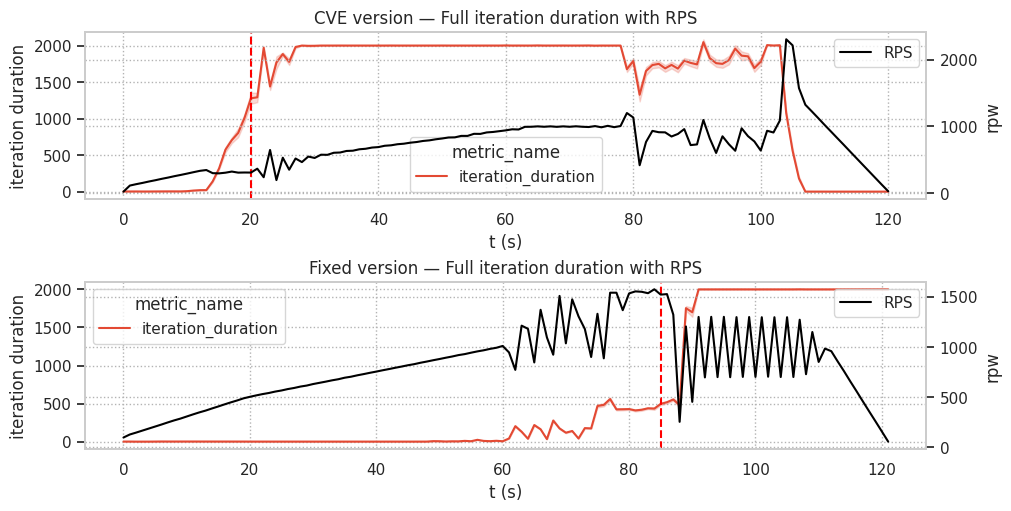

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)

metrics = ["iteration_duration"]
m_cve = df_cve_norm['metric_name'].isin(metrics)
m_fixed = df_fixed_norm['metric_name'].isin(metrics)

sns.lineplot(data=df_cve_norm.loc[m_cve], x="t", y="metric_value", hue="metric_name", ax=axs[0])
sns.lineplot(data=df_fixed_norm.loc[m_fixed], x="t", y="metric_value", hue="metric_name", ax=axs[1])

# Show saturation start
if cve_win5_sat["t_start"] is not None:
    axs[0].axvline(cve_win5_sat["t_start"], linestyle="--", color="red", label="CVE saturation start")

if fixed_win5_sat["t_start"] is not None:
    axs[1].axvline(fixed_win5_sat["t_start"], linestyle="--", color="red", label="FIX saturation start")

ax_rps_cve = axs[0].twinx()
sns.lineplot(df_rps_cve,x="t",y="rpw",ax=ax_rps_cve,color="black",label="RPS")

ax_rps_fixed = axs[1].twinx()
sns.lineplot(df_rps_fixed,x="t",y="rpw",ax=ax_rps_fixed,color="black",label="RPS")

axs[0].set_title("CVE version — Full iteration duration with RPS")
axs[0].set_xlabel("t (s)")
axs[0].set_ylabel("iteration duration")
axs[1].set_title("Fixed version — Full iteration duration with RPS")
axs[1].set_xlabel("t (s)")
axs[1].set_ylabel("iteration duration")

plt.show()

In [27]:
df_cve_sat_tmp = cve_win5_sat["df_p95w"][['t', 'p95']].copy()
df_cve_sat_tmp['version'] = 'cve'

df_fixed_sat_tmp = fixed_win5_sat["df_p95w"][['t', 'p95']].copy()
df_fixed_sat_tmp['version'] = 'fixed'

df_sat_compare = pd.concat([df_cve_sat_tmp, df_fixed_sat_tmp], ignore_index=True)

print(f"{df_sat_compare.shape} - Saturation comparison data shape")

print(f"Columns of saturation comparison data: {df_sat_compare.columns}")

(50, 3) - Saturation comparison data shape
Columns of saturation comparison data: Index(['t', 'p95', 'version'], dtype='object')


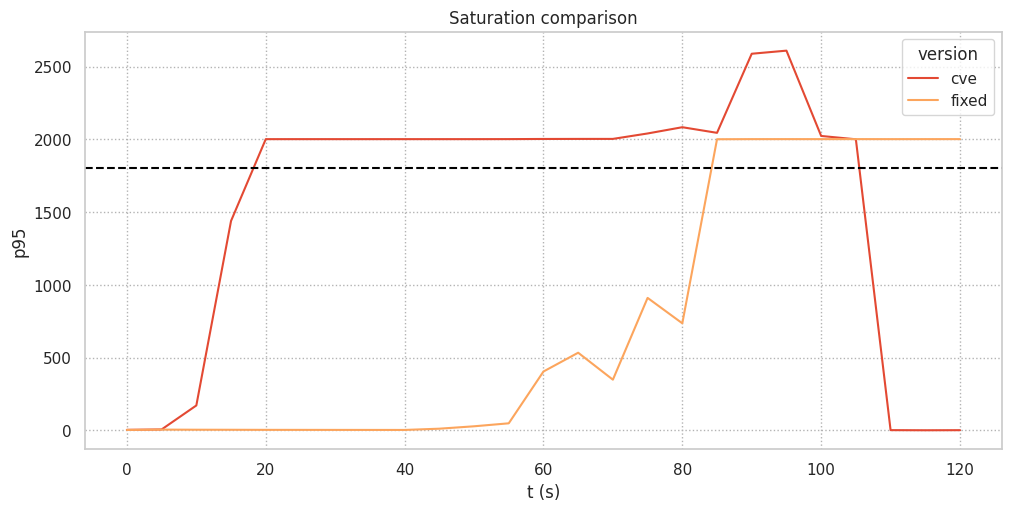

In [28]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

sns.lineplot(data=df_sat_compare, x="t", y="p95", hue="version", ax=ax)

ax.axhline(threshold_ms, linestyle="--", color="black")

ax.set_xlabel("t (s)")
ax.set_ylabel("p95")
ax.set_title("Saturation comparison")

plt.show()